# Deep Learning Utilizando PyTorch I
## Convolución aplicada a imágenes a color
Una imagen a color se representa mediante un arreglo cuyas dimensiones son:
$$WxHxC$$

Donde:
*W*: Ancho de la imagen en pixeles
*H*: Alto de la imagen en pixeles
*C*: Número de canales correspondiente a los colores. En RGB es 3.

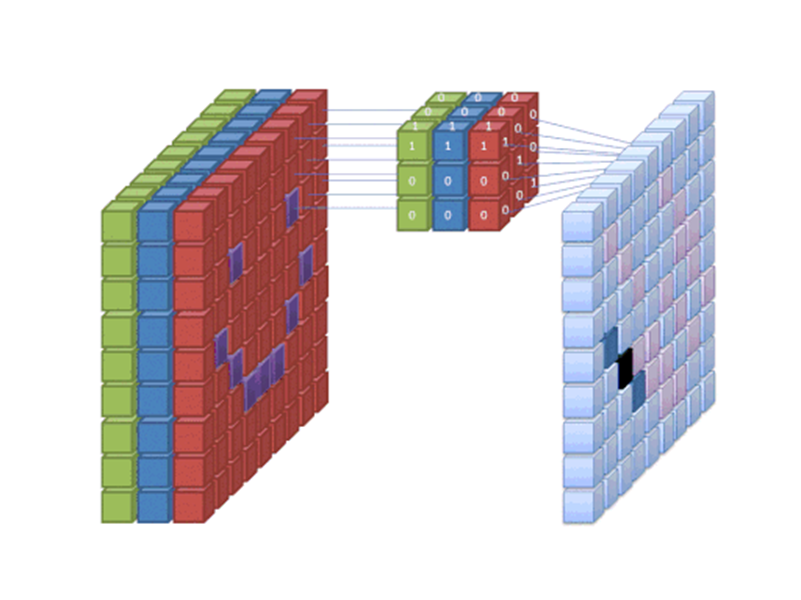

El kernel se convoluciona con el arreglo de entrada, donde el canal correspondiente al canal verde se convoluciona con el kernel marcado en color verde. Se realzia el mismo proceso que una convolución normal para una imagen monocromática.
Si el kernel es de 3x3x3, el resultado de un paso en la convolución será la suma de 27 números. Los productos resultantes de los filtros 3x3x3 multiplicados cada uno por sus valores correspondientes en los pixeles de la imagen, generando un único valor.

En el siguiente paso, el kernel de 3x3x3 se desliza una cantidad de pixeles *s*, si el stride es 1, se repite el proceso de suma de 27 produtctos, generado el siguiente elemento para el arreglo de salida. Así, el proceso continúa hasta terminar con todas las posiciones de la imagen o arreglo de entrada.
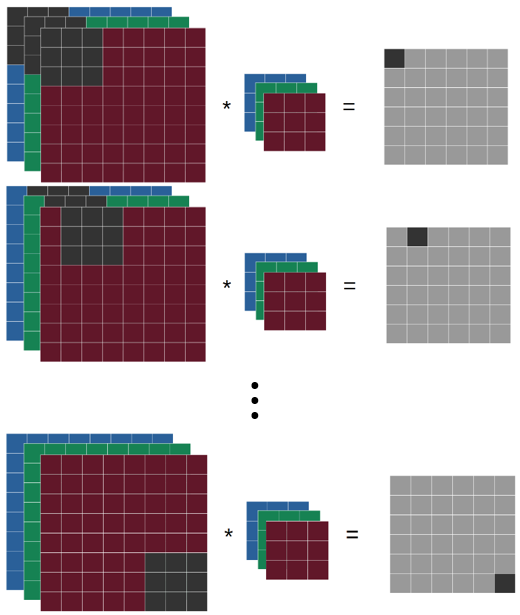

Si se tiene un arreglo con dimensiones $w\times h\times c$, donde *w* es el ancho, *h*, la altura y *c* el número de canales, y lo convolucionamos con un filtro de dimensiones $k \times k \times c$, donde *f* es el tamaño del kernel y *c* el número de canales, el resultado será:

$$(\frac{h+2p-k}{s}+1)\times(\frac{w+2p-k}{s}+1)\times NumFiltros$$

Cada uno de los elementos en el arreglo de salida es el resultado de una operación lineal entre el filtro y la parte correspondiente del arreglo de entrada, por lo que cada elemento del arreglo resultante puede interpretarse como una neurona.

Al igual que en las redes neuronales tipo perceptrón multicapa, se puede sumar un *bias b* a cada valor del arreglo. El mismo valor escalar *b* se suma a cada uno de los elementos del arreglo de salida, a los cuales también se les aplica una función no lineal.

## Arquitectura de una red neuronal convolucional e implementación usando PyTorch
Supongamos que en la primera capa de la red neuronal convolucional tiene una entrada con imágenes a color de 32x32 con 3 canales. Y la primera capa tiene 8 filtros de 3x3x3
¿De qué tamaño es su salida? Asume que se tiene un stride de uno y paddding igual a uno.

$$(\frac{32+2(1)-3}{1}+1)\times(\frac{32+2(1)-3}{1}+1)\times8 = 32\times32\times8$$

Dado que se utiliza *padding* de uno y *stride* de uno, **se conservan las dimensiones originales**.

¿Cuántos elementos se aprenderían en una capa de una red convolucional con estas características? 27 elementos por kernel, más 1 bias, para un total de 28 parámetros por filtro. Considerando que son 8 filtros, se tiene un total de **28x8** parámetros, es decir, 224 parámetros que se van a aprender derivados de esta capa.

El **número de parámetros que se aprenden** no tiene relación con las dimensiones de la imagen de entrada.

Por ejemplo, si la primera capa tiene 20 neuronas se tendría una matriz de pesos de:

$$20\times32\times32\times3 + 20=61440 + 20$$

Si se tiene un *minibatch* con *m* imágenes en PyTorch, se tiene de salida con dimensiones:

$$m\times NumFiltros\times(\frac{h+2p-k}{s}+1)\times(\frac{w+2p-k}{s}+1)$$


El proceso de **pooling** consiste en reducir las dimensiones $h \times w$ de una matriz a $h/2 \times w/2 $. También se representa mediante la aplicación de un filtro con atributos de dimensiones y *stride*.
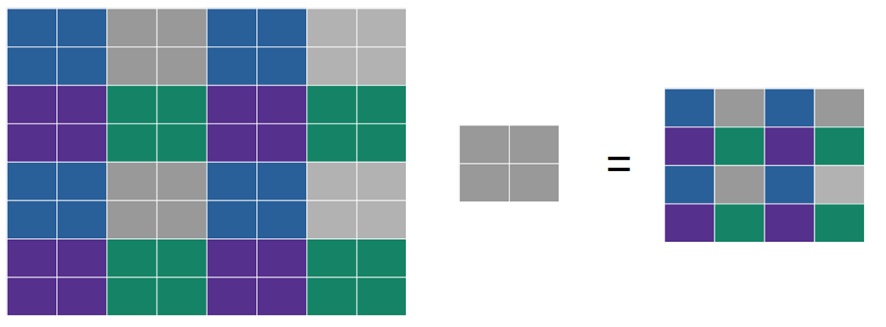

***Average Pooling*** consiste en reemplazar el valor de cada segmento de 2x2 por un promedio de los cuatro elementos.

***Max Pooling*** consiste en tomar el mayor valor del segmento de 2x2 del arreglo original. Es el método más utilizado, ya que, en general, arroja mejores resultados.

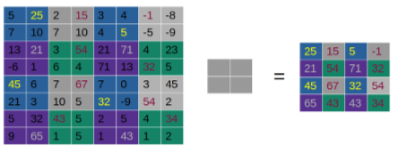

In [ ]:
# MaxPooling
import numpy as np
import torch
import torch.nn as nn
nn.MaxPool2d()

Se tienen 5 razas de gatos, y las imágenes son a color de 64x64. Con estas características se va a construir un modelo que tenga dos capas ocultas con redes neuronales convolucionales, más una capa de salida Fully Connected con cinco neuronas, una para cada clase.

1. Si la entradad es de 64x64x3, el kernel de convolución debe tener también tres canales, por lo que, si se decide utilizar un filtro de 3x3, en total se tendría de 3x3x3. Donde la última dimensión son los canales de entrada. *Padding y stride* de uno. Así mismo, se aplicarán 16 filtros de 3x3x3. La salida del modelo será de 64x64x16, donde se preservan las dimensiones de ancho y alto, y los 16 filtros.

2. Se hará MaxPooling de 2x2, con un *padding* de cero y un *stride* de dos. El resultado será una salida de 32x32x16

3. La salida de la capa *max pooling* se ingresa a una segunda capa de red neuronal convolucional. Esta capa cuenta con 32 filtros de las mismas caracteríticas que la capa previa, por lo que se conservan las dimensiones de ancho y alto. Por lo que la salida de la segunda capa será de 32x32x32. A su vez, la salida será pasada por la segunda capa de *max pooling*, por lo que se tendrá una salida de 16x16x32.

4. Finalmente, para poder reconocer cinco clases es necesario convertir el arreglo de salida de la última capa de *max pooling* en un vector. La dimensión del vector será igual al número de elementos totales del arreglo, es decir, el producto de 16x16x32 que es igual a 8192. Por lo tanto, la matriz de pesos sinápticos asociada con la capa de salida lineal es de 5x8192.
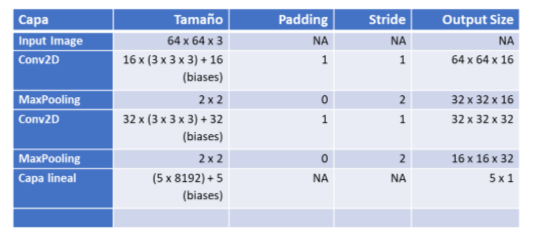

In [1]:
# Modelo
import torch
import torch.nn as nn

model1 = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=16, # Imagen a Color, 16 características
              kernel_size=3,stride=1,padding=1,bias=True), # kernel de 3x3
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(in_channels=16,out_channels=32, # Se reciben 16 canales y produce 32
              kernel_size=3,stride=1,padding=1,bias=True),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Flatten(),
    nn.Linear(in_features=16*16*32,out_features=5,bias=True),
)


# Deep Learning usando PyTorch II

## Implementación de loop de entrenaniemto y funciones para evaluar el desempeño del modelo utilizando PyTorch

Tu cliente, la clínica veterinaria “El perro es el mejor amigo del gato”, ha decidido que además de clasificar gatos, es necesario reconocer la raza de perros, ya que se han dado cuenta de que existen errores en el registro de ambos animales. Afortunadamente, llevan buen control de las mascotas y tienen una base de datos con imágenes de gatos y perros. Dicha base es de 20,000 imágenes: 10,000 de gatos y 10,000 de perros, como se muestra en la siguiente tabla:
Total de imágenes	20,000
Razas de gatos	10
Razas de perros	10
Imágenes por raza	1000


In [2]:
import numpy as np

# Minibatches
def create_minibatches(x,y,mb_size):
    total_data = x.shape[0]
    idxs = np.arange(total_data)
    np.random.shuffle(idxs)
    x = x[idxs]
    y = y[idxs]
    return ((x[i:i+mb_size],y[i:i+mb_size]) for i in range(0,total_data,mb_size))

In [6]:
# Generar loop de entrenamiento
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def train(model,optimiser,mb_size,epochs=100):
    for epoch in range(epochs):
        for (xi,yi) in create_minibatches(x_train,y_train,mb_size):
            model.train()
            scores = model(xi)
            cost = F.cross_entropy(input=scores,target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        if epoch%20 ==0:
            print(f'Epoch_: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model,x_val,y_val,mb_size)}')


In [8]:
model1 = nn.Sequential(nn.Linear(in_features=3,out_features=10),nn.ReLU(),
                       nn.Linear(in_features=10,out_features=10),nn.ReLU(),
                       nn.Linear(in_features=10,out_features=10),nn.ReLU(),
                       nn.Linear(in_features=10,out_features=5))
optimiser = optim.SGD(model1.parameters(),lr=1e-3)

In [11]:
# accuracy
def accuracy(model,x,y,mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device = device)
    with torch.no_grad():
        for (xi,yi) in create_minibatches(x,y,mb_size):
            xi = xi.to(device=device,dtype=torch.float32)
            yi = yi.to(device=device,dtype=torch.long)
            scores = model(x1)
            _,pred = scores.max(dim=1)
            num_correct += (pred==yi.squeeze()).sum()
            num_total += pred.size(0)
            return float(num_correct)/num_total

## Regularización para Deep Learning

La **regularización** son una serie de técnicas que limitan la capacidad de aproximanción delm odelo y la generación de modelos muy complejos que tienden a memorizar los datos de entrenamiento, resultando en una generalización limitada.

Si se llama a la función de costo *J*, está dada por la suma de las funciones de pérdida para cada elemento en el dataset:

$$J(w,b) = \frac{1}{m}\sum L_{i}$$

Con **regularización** se agrega un valor adicional a la función de costo, de tal forma que fuerce a los valores del parámetro *W* a portarse bien.

$$J(W,b) = \frac{1}{m}\sum L_{i} + \lambda||W^2||_{2}$$

Donde:

$$||W^2||_{2} = \sum_{j}\sum_{k}W_{j,k}^2$$

El cuadrado de la norma o distancia.

El resultado de este proceso, es que, aunque el valor de la función de costo sea mayor, el desempeño en el set de pruebas mejora al mantener valores de los parámetros *W* más pequeños. Este tipo de regularización L2 también se conoce como **weight decay**. También se tiene un nuevo hiper parámetro: $\lambda$, el cual se tiene que seleccionar en combinación con el *learning rate*.

Enter más grande sea el valor de lambda, los parámetros de *W* serán más pequeños, por lo que a mayores valores de lambda se dice que hace una **regularización más fuerte**.

Se tiene una entrada

$$ X = [2,2,2,2] $$
y unos parámetros candidatos
$$ W_{1} = [1,0,0,0]$$
$$ W_{2} = [0.25,0.25,0.25,0.25]$$

El resultado del score:

$$ W_{1}^{T}X = W_{2}^{T}X= 2 $$
Es decir, es una igualdad.

Otro tipo de regularización es ***Dropout***, el cual consiste en asignar de forma aleatoria algunas activaciones de la red neuronal a un valor de cero, con cierto probabilidad, siendo la probabilidad más común 50%.

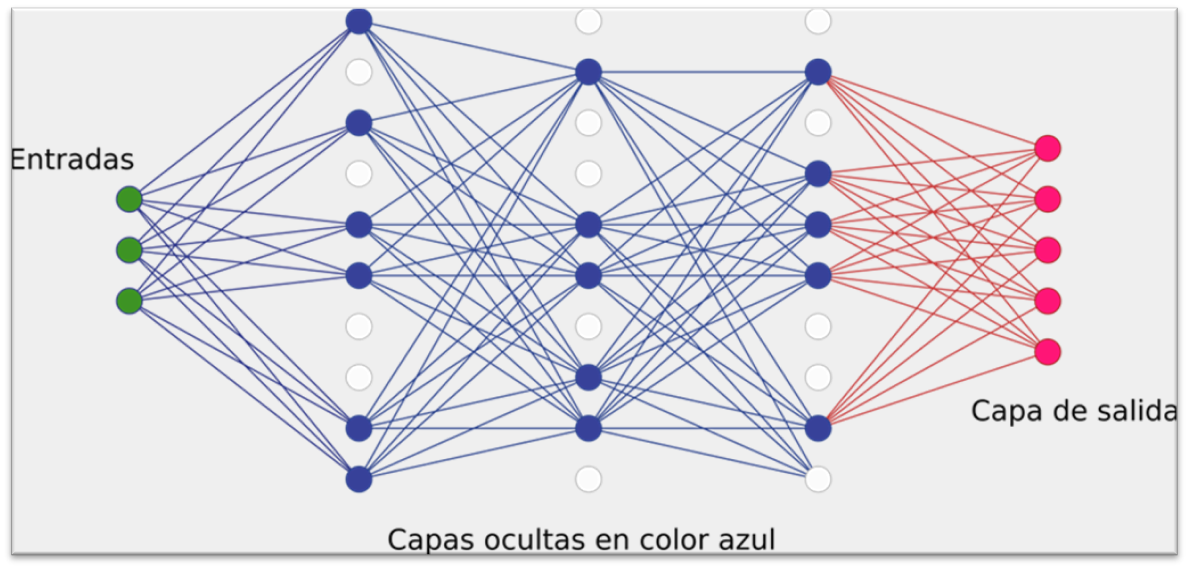




Al disminuir la capacidad, la red deja de depender tanto en los parámetros. Esta se vuelva más resistente a variaciones.

In [12]:
# Dropout
import numpy as np
drop_prob = 0.5
def forward_dropout(X,p=drop_prob):
    A1 = np.maximun(0,np.dot(W1,X)+b1)
    mask1 = (np.random.rand(A1.shape)<p)/p
    A1 *=mask1
    return np.dot(W2,A1) + b2

En una red neuronal:

In [13]:
import torch
import torch.nn as nn
model1 = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1,
              bias = True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.MaxPool2d((2,2)),

    nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,
              bias = True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.MaxPool2d((2,2)),

    nn.Flatten(),
    nn.Linear(in_features=16*16*32,out_features=64,bias=True)
    )